### 


# Les archives Twitter de WeRateDogs

## Table des matières
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Traitement des données (collecte, évaluation, nettoyage)</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
### A) Introduction
Le jeu de données, que nous allons traiter et analyser, est l'archive de tweets connue sous le nom de WeRateDogs. Ce compte twitter évalue les chiens des gens avec un commentaire humoristique sur le chien. L'objectif de ce projet consiste à traiter les données : rassembler les données à partir de diverses sources et dans divers formats, évaluer leur qualité et leur propreté, puis les nettoyer.

Nous importons toutes les bibliothèques nécessaires au projet :

In [1]:
import requests
import pandas as pd
import numpy as np
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<a id='wrangling'></a>
### B) Traitement des données (collecte, évaluation, nettoyage)
#### 1) La collecte
La collecte est la première étape du processus d'extraction des données. Dans cette partie, nous téléchargeons les fichiers .csv, .tsv et json de la page web d'Udacity. Nous avons au total trois sources :

###### 1.1) Archive Twitter améliorée
Les archives Twitter de WeRateDogs ont été téléchargées manuellement depuis la page web d'Udacity : twitter_archive_enhanced.csv. Cette archive Twitter contient les données de base des plus de 5000 tweets 

###### 1.2) Fichier de prédiction d'image
Nous téléchargeons le fichier à partir de l'URL : https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv , en utilisant la bibliothèque Requests.

Le fichier de prédiction d'image (image_predictions.tsv) nous donne des informations sur le brend de chien présent dans chaque tweet. Il contient en particulier les trois meilleures prédictions de brend pour chaque ID de tweet, l'URL de l'image et le numéro de l'image correspondant à la prédiction la plus sûre.

######  1.3)Données JSON du Tweet
Nous téléchargeons egalement sur le site de Udacity. Les données JSON de chaque tweet sont écrites sur leur propre ligne dans un fichier appelé tweet_json.txt. Le fichier contient des informations supplémentaires : le nombre de retweets et le nombre de favoris.

In [2]:
reponse = requests.get(' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', auth=('user', 'pass'))
with open ('image_predictions.tsv',mode='wb') as file:
    file.write(reponse.content)
df_imagePred=pd.read_csv("image_predictions.tsv",sep='\t')
df_imagePred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [3]:
df_arch_enh=pd.read_csv('twitter-archive-enhanced.csv')
df_arch_enh.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [4]:
# From the text file read the JSON data
selected_attr = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        
        # create a dictionary with the JSON data, then add to a list tweet_id, favorites, retweets from the JSON data
        selected_attr.append({'tweet_id': json_data['id'],
                             'favorites': json_data['favorite_count'],
                             'retweets': json_data['retweet_count']})
# convert the tweet JSON data dictionary list to a DataFrame
tweet_selected_attr = pd.DataFrame(selected_attr, columns=['tweet_id','favorites','retweets'])
# print out few raw dataframe tweet_selected_attr
tweet_selected_attr.head(5)

,tweet_id,favorites,retweets
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


### 2) Evaluation

Dans cette section, j'évalue les données recueillies précédemment. L'évaluation des données est la deuxième étape du traitement des données. Le but de ce processus est d'identifier les problèmes de qualité des données (problèmes de contenu) et le manque de rangement (problèmes structurels).

Ce projet demande que seuls les tweets avec des évaluations originales avec des images, sans retweets, soient considérés. Ces deux informations se trouvent dans le fichier d'archive des tweets. Ensuite, les tweets originaux seront fusionnés avec la prédiction d'image et les données Json.

In [5]:
df_arch_enh.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### a) Les valeurs manquantes dans plusieurs variables de notre Data Frame 


In [6]:
df_arch_enh.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

### b ) La colonnes sources contiennent des codes html

In [7]:
df_arch_enh.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

### c) Les differents nom de chien et leur nombres 

On peut constater qu'on a des chien avec pour nom  `a`  , ce qui n'est pas vrai !!

In [8]:
df_arch_enh.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
          ... 
Timmy        1
Horace       1
Nugget       1
Barclay      1
Stefan       1
Name: name, Length: 957, dtype: int64

### d) Les noms des colonnes ne donnent pas assez d'information sur le contenu de la variable

In [9]:
df_imagePred.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### e) Les valeurs dupliquées 

In [10]:
df_imagePred.p3_conf.duplicated().sum()

69

### f) L'ensemble de données `image_predictions`a 2075 lignes, tandis que l'ensemble de données de `twitter-archive-enhanced` a 2356 lignes 

In [11]:
df_arch_enh.shape

(2356, 17)

In [12]:
df_imagePred.shape

(2075, 12)

### g) Le temps est de type Objet

In [13]:
df_arch_enh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
df_imagePred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Problèmes de qualité :

 #### Données d'archives Tweeter
 
    Problème de qualité: 
    -Les colonnes contenant des informations sur les retweets - retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp contiennent au total 181 valeurs non nulles.
    
    -Les colonnes contenant des informations sur les réponses - reply_to_status_id, in_reply_to_user_id contiennent au total 78 valeurs non nulles.
    
    -La colonne avec les informations sur les urls contient 2297 expanded_urls non nulles, et 59 tweets sans urls (1 est un retweet, et 55 sont des réponses) ; et les trois autres sont présents dans les données JSON mais pas dans le fichier de prédiction Imagine.

    -Nom de colonne : les chiens sans noms sont 'None' au lieu de NaN (ils sont 745) et certains noms (109 au total) ne sont pas corrects.

    -Le format de la colonne timestamp n'est pas correct (data, time, +000) et il devrait être de type datetime, et non de type string.

    -les colonnes 'dog stages' - doggo, floofer, pupper, et puppo ont des valeurs qui sont la chaîne "None" au lieu de NaN

    -Colonne 'rating_denominator' : il y a 17 tweets originaux avec rating_denominator différent de 10 (13 d'entre eux concernent plusieurs chiens/chiens, et peuvent être supprimés).

       - Colonne 'rating_numerator' : elle contient 28 tweets avec rating_numerator supérieur ou égal à 15. La valeur maximale est de 1776, ce qui n'a pas de sens. Pour les tweets avec rating_denominator égal à 10, il y a 12 tweets avec rating_numerator >= 15 (7 d'entre eux sont des retweets et des réponses, et 5 des tweets originaux).

    - Colonne tweet_id : c'est un type numérique (int64). Il devrait être de type chaîne de caractères



### Nettoyage 

###  Fraire une copies des data frame

In [15]:
twitter_archive_clean = df_arch_enh.copy()
image_prediction_clean = df_imagePred.copy()
tweet_json_clean = tweet_selected_attr.copy()

### Garder les évaluations originales (pas de retweets) qui ont des images.

    D'après les informations, il y a 181 valeurs dans retweeted_status_id et retweeted_status_user_id.Supprimez les retweets.Une fois que j'aurai fusionné twitter_archive et image_prediction, je ne garderai que les évaluations avec des images.

In [16]:
#CODE: 
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]

#TEST
print(sum(twitter_archive_clean.retweeted_status_user_id.value_counts()))

0


###  Supprimons les colonnes nous apportant peu d'informations 

In [17]:
#CODE: Delete columns no needed
twitter_archive_clean = twitter_archive_clean.drop(['source',
                                                    'in_reply_to_status_id',
                                                    'in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp', 
                                                    'expanded_urls'], 1)

###  Types de données erronés (colonnes doggo, floofer, pupper et puppo)

Fondez les colonnes doggo, floofer, pupper et puppo en colonnes dogs et dogs_stage. Puis déposez dogs. Trier par dogs_stage dans l'ordre pour ensuite supprimer les doublons basés sur tweet_id sauf pour la dernière occurrence.

In [18]:
#CODE: Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=['tweet_id', 'timestamp','text','rating_numerator','rating_denominator','name'],var_name='dogs', value_name='dogs_stage')                         
                                                               
#CODE: drop dogs
twitter_archive_clean = twitter_archive_clean.drop('dogs', 1)

#CODE: Sort by dogs_stage then drop duplicated based on tweet_id except the last occurrence
twitter_archive_clean = twitter_archive_clean.sort_values('dogs_stage').drop_duplicates(subset='tweet_id', 
                                                                                        keep='last')
#TEST
twitter_archive_clean['dogs_stage'].value_counts()

None       1831
pupper      234
doggo        75
puppo        25
floofer      10
Name: dogs_stage, dtype: int64

### Séparer `timestamp` en jour - mois - année (3 colonnes)

Convertissez d'abord `timestamp` en date. Puis extraire l'année, le mois et le jour dans de nouvelles colonnes. Enfin, supprimez la colonne timestamp.

In [19]:
#CODE: convert timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
#extract year, month and day to new columns
twitter_archive_clean['year'] = twitter_archive_clean['timestamp'].dt.year
twitter_archive_clean['month'] = twitter_archive_clean['timestamp'].dt.month
twitter_archive_clean['day'] = twitter_archive_clean['timestamp'].dt.day
#Finally drop timestamp column
twitter_archive_clean = twitter_archive_clean.drop('timestamp', 1)
#TEST
list(twitter_archive_clean)

['tweet_id',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dogs_stage',
 'year',
 'month',
 'day']

###  Correction du  numérateurs

In [20]:
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean[['rating_numerator','rating_denominator']].astype(float)
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2095 to 7298
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   text                2175 non-null   object 
 2   rating_numerator    2175 non-null   float64
 3   rating_denominator  2175 non-null   float64
 4   name                2175 non-null   object 
 5   dogs_stage          2175 non-null   object 
 6   year                2175 non-null   int64  
 7   month               2175 non-null   int64  
 8   day                 2175 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 169.9+ KB


In [21]:
#First change numerator and denominators type int to float to allow decimals 
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean[['rating_numerator','rating_denominator']].astype(float)

#Update numerators
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
twitter_archive_clean.loc[(twitter_archive_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

#TEST
with pd.option_context('max_colwidth', 200):
    display(twitter_archive_clean[twitter_archive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
42,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
3685,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.50,10.0
3708,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0
2733,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
4967,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0


### Ajustement du Dénominateurs 

In [22]:
#CODE: Create a new column with rating in float type to avoid converting all int column to float
twitter_archive_clean['rating'] = 10 * twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator'].astype(float)

#TEST
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating
3683,681579835668455424,This is Apollo. He thought you weren't coming ...,8.0,10.0,Apollo,None,2015,12,28,8.0
3868,675146535592706048,This is Coops. He's yelling at the carpet. Not...,7.0,10.0,Coops,None,2015,12,11,7.0
2887,760656994973933572,This is Rose. Her face is stuck like that. 11/...,11.0,10.0,Rose,None,2016,8,3,11.0
3333,705102439679201280,This is Terrenth. He just stubbed his toe. 10/...,10.0,10.0,Terrenth,None,2016,3,2,10.0
4211,668542336805281792,There's a lot going on here but in my honest o...,10.0,10.0,None,None,2015,11,22,10.0


### Les valeurs dupliquées de la  colonne Drop 66 jpg_url 

In [23]:
#CODE: Delete duplicated jpg_url
image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last')

#TEST
sum(image_prediction_clean['jpg_url'].duplicated())

0

###  Créer 1 colonne pour la prédiction d'image et 1 colonne pour le niveau de confiance

Créer une fonction où je garde la première prédiction vraie ainsi que le niveau de confiance comme nouvelles colonnes.

In [24]:
#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
dog_type = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(image_prediction_clean):
    if image_prediction_clean['p1_dog'] == True:
        dog_type.append(image_prediction_clean['p1'])
        confidence_list.append(image_prediction_clean['p1_conf'])
    elif image_prediction_clean['p2_dog'] == True:
        dog_type.append(image_prediction_clean['p2'])
        confidence_list.append(image_prediction_clean['p2_conf'])
    elif image_prediction_clean['p3_dog'] == True:
        dog_type.append(image_prediction_clean['p3'])
        confidence_list.append(image_prediction_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

#series objects having index the image_prediction_clean column.        
image_prediction_clean.apply(image, axis=1)

#create new columns
image_prediction_clean['dog_type'] = dog_type
image_prediction_clean['confidence_list'] = confidence_list

In [25]:
#drop rows that has prediction_list 'error'
image_prediction_clean = image_prediction_clean[image_prediction_clean['dog_type'] != 'Error']

#TEST: 
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         1691 non-null   int64  
 1   jpg_url          1691 non-null   object 
 2   img_num          1691 non-null   int64  
 3   p1               1691 non-null   object 
 4   p1_conf          1691 non-null   float64
 5   p1_dog           1691 non-null   bool   
 6   p2               1691 non-null   object 
 7   p2_conf          1691 non-null   float64
 8   p2_dog           1691 non-null   bool   
 9   p3               1691 non-null   object 
 10  p3_conf          1691 non-null   float64
 11  p3_dog           1691 non-null   bool   
 12  dog_type         1691 non-null   object 
 13  confidence_list  1691 non-null   object 
dtypes: bool(3), float64(3), int64(2), object(6)
memory usage: 163.5+ KB


### Supprimer les colonnes qui ne seront pas utilisées pour l'analyse.

In [26]:
#CODE: print list of image_prediction columns
print(list(image_prediction_clean))

#Delete columns
image_prediction_clean = image_prediction_clean.drop(['img_num', 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#TEST
list(image_prediction_clean)

['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'dog_type', 'confidence_list']


['tweet_id', 'jpg_url', 'dog_type', 'confidence_list']

### 3) Stockage, et visualisation des données

In [27]:
df_twitter=pd.merge(twitter_archive_clean,image_prediction_clean,on="tweet_id",how="outer")
df_twitter.head(3)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list
0,667443425659232256,Exotic dog here. Long neck. Weird paws. Obsess...,6.0,10.0,None,None,2015.0,11.0,19.0,6.0,NaN,NaN,NaN
1,667453023279554560,Meet Cupcake. I would do unspeakable things fo...,11.0,10.0,Cupcake,None,2015.0,11.0,19.0,11.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,Labrador_retriever,0.82567
2,667455448082227200,This is Reese and Twips. Reese protects Twips....,7.0,10.0,Reese,None,2015.0,11.0,19.0,7.0,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,Tibetan_terrier,0.676376


In [28]:
#Store the clean DataFrame in a CSV file
df_twitter.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

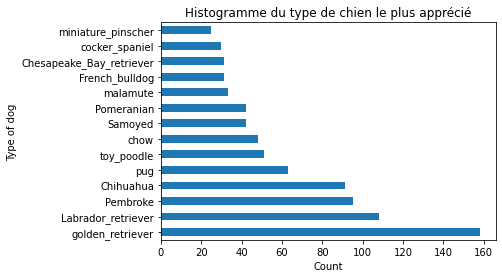

In [36]:
df_dog_type = df_twitter.groupby('dog_type').filter(lambda x: len(x) >= 25)

df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Histogramme du type de chien le plus apprécié')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

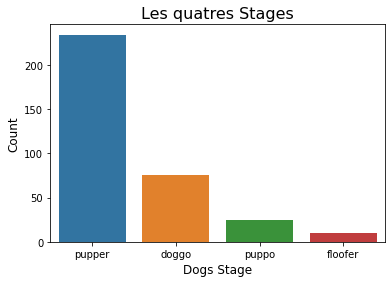

In [35]:
stages_dog =df_twitter['dogs_stage'].value_counts()[1:5].index
sns.countplot(data = df_twitter, x = 'dogs_stage', order = stages_dog)
plt.xlabel('Dogs Stage', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Les quatres Stages',fontsize=16)
plt.savefig('common-stage.png');

### 
       La plupart des chiens sont classés dans le stade "Pupper".

   Analyse : 
         
         Corrélation entre le nombre de Retweets et le nombre de Favoris
        Il est évident que lorsqu'une photo est retweetée, elle sera plus favorisée que les autres posts qui ont reçu moins d'évaluation et moins de visibilité. Nous pouvons voir ces aspects dans les graphiques suivants :

        -'Corrélation entre les retweets et les favoris' : si le post est retweeté plus de fois, il aura plus de visibilité.

        -'Retweets counts - Ratings' montre que les chiens les mieux notés reçoivent plus de retweets.

       - L'indicateur 'Favorites counts - Ratings' montre que les chiens les mieux notés reçoivent plus de favoris.

In [31]:
df_dog_type_mean = df_twitter.groupby('dog_type').mean()
df_dog_type_mean

,tweet_id,rating_numerator,rating_denominator,year,month,day,rating
dog_type,,,,,,,
Afghan_hound,817138477394806144,8.000000,10.0,2016.500000,6.000000,16.000000,8.000000
Airedale,718448940360117248,9.833333,10.0,2015.583333,8.750000,15.916667,9.833333
American_Staffordshire_terrier,759728394572314624,10.312500,10.0,2016.187500,5.250000,15.000000,10.312500
Appenzeller,793933403993278464,11.000000,10.0,2016.500000,4.500000,18.500000,11.000000
Australian_terrier,778592105778309120,11.500000,10.0,2016.500000,3.500000,7.000000,11.500000
...,...,...,...,...,...,...,...
toy_poodle,721851366722128768,11.020000,10.0,2015.700000,7.640000,13.840000,11.020000
toy_terrier,716637533784255104,10.333333,10.0,2015.333333,11.333333,23.333333,10.333333
vizsla,741726335852998912,10.846154,10.0,2015.769231,9.076923,17.769231,10.846154


In [32]:
df_dog_type_mean.head()

,tweet_id,rating_numerator,rating_denominator,year,month,day,rating
dog_type,,,,,,,
Afghan_hound,817138477394806144,8.000000,10.0,2016.500000,6.00,16.000000,8.000000
Airedale,718448940360117248,9.833333,10.0,2015.583333,8.75,15.916667,9.833333
American_Staffordshire_terrier,759728394572314624,10.312500,10.0,2016.187500,5.25,15.000000,10.312500
Appenzeller,793933403993278464,11.000000,10.0,2016.500000,4.50,18.500000,11.000000
Australian_terrier,778592105778309120,11.500000,10.0,2016.500000,3.50,7.000000,11.500000


In [33]:
df_dog_type_sorted = df_dog_type_mean['rating'].sort_values()

df_dog_type_sorted

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
soft-coated_wheaten_terrier     8.800000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
                                 ...    
Border_terrier                 12.142857
briard                         12.333333
Irish_setter                   12.333333
Saluki                         12.500000
Bouvier_des_Flandres           13.000000
Name: rating, Length: 113, dtype: float64

In [34]:
df_dog_type_count = df_twitter.groupby('dog_type').count()
df_dog_type_count

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,confidence_list
dog_type,,,,,,,,,,,,
Afghan_hound,3,2,2,2,2,2,2,2,2,2,3,3
Airedale,12,12,12,12,12,12,12,12,12,12,12,12
American_Staffordshire_terrier,16,16,16,16,16,16,16,16,16,16,16,16
Appenzeller,2,2,2,2,2,2,2,2,2,2,2,2
Australian_terrier,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
toy_poodle,51,50,50,50,50,50,50,50,50,50,51,51
toy_terrier,3,3,3,3,3,3,3,3,3,3,3,3
vizsla,14,13,13,13,13,13,13,13,13,13,14,14


### THANK !!!
